In [ ]:
#@title Copyright 2022 Fuzhan Rahmanian (KIT) fuzhan.rahmanian@kit.edu

# Importing the dataset

The dataset is shared over GoogleDrive and unzipped in the workling directory. The zip file, contains a "tri_data_share.pck" which is pickle file.





In [ ]:
# For local download, please use this link.
# https://drive.google.com/file/d/1-jRaEUxu3lHik4itFu9MZVJ8j9rDRCpm/view?usp=sharing
!wget -O tri_data_share.zip https://drive.google.com/u/0/uc?id=1-jRaEUxu3lHik4itFu9MZVJ8j9rDRCpm&export=download
!unzip tri_data_share.zip

For this tutorial, we need some python packages. It is custom to import the packages at the beginning of the file, before writing any actual code. We need the following packages:

*   pickle for opening the dataset
*   pydot is an interface to Graphviz
*   numpy for all type of algebraic calculations
*   PyPlot from matplotlib used for plotting
*   export_graphviz for displaying ML trees
*   RandomForestRegressor and GaussianProcessRegressor from sklear
*   train_test_split also from sklearn for splitting the data
*   Image from IPython.display to display images



After importing the pickel package, the file can be loaded and read. 

In [ ]:
import pickle
import pydot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from IPython.display import Image

## **The dataset**

It is time to importing the data the pickle.load function.
This dataset contains electrocatalytic activity (overpotential) for the oxygen evolution reaction (OER) on **4** chemical spaces. Each of this space, holds **2121** unique compositions comprising all possible unary, binary, ternary and quaternary compositions from a 6 element set with 10 at% intervals.   

| Plate ID      | Label   | Composition system  |
| ------------- |:-------:| -------------------:|
| 3496          | A       | Mn–Fe–Co–Ni–La–Ce   |
| 3851          | B       | Mn–Fe–Co–Ni–Cu–Ta   |
| 3860          | C       |  Mn–Fe–Co–Cu–Sn–Ta |
| 4098          | D       | Ca–Mn–Co–Ni–Sn–Sb	  |

The chemical spaces are the keys of the dataset. 

[Reference](https://pubs.rsc.org/en/content/articlehtml/2020/sc/c9sc05999g)

In [ ]:
# Open the downloaded data
all_data = pickle.load(open( "tri_data_share.pck", "rb" ))
print(all_data.keys())

We will select the space C with ID 3860.
This, in turn, contains the keys: fom (Figure of Merit), sno, runit, comp (composition).

The input value of our ML model will be the compositions and the output values will be the figure of merit which shows the overpotential (V).

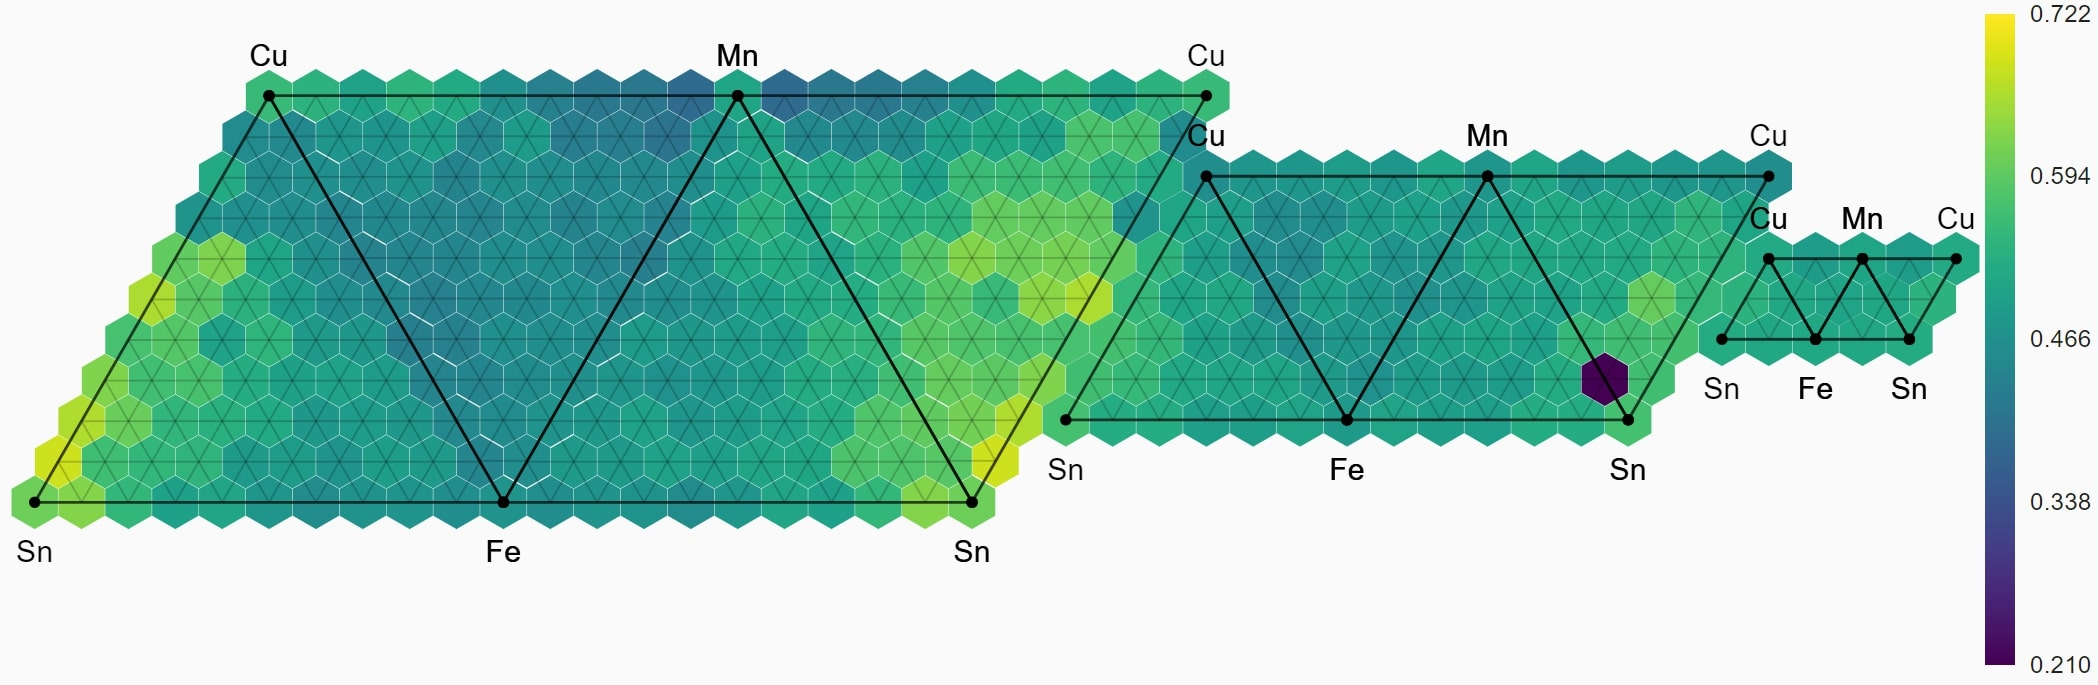

In [ ]:
# Select the space C with id 3890
data = all_data["3860"]

print("Here is the overpotential")
print(data["fom"])


print("Here is the composition")
print(data["comp"])

## **Prepare the data for the machine learning model**

In ML learning, we need to divide the data into features (composition values) and targets/labels (the values that we want to predict, in this case, our overpotential values). 

In [ ]:
# Selecting feature and labels
features = data["comp"]
labels = data["fom"]

For supervised learning, the data is spitted into two: training and tests sets. The training set is labeled and it will learn the patterns that lead to a prediction. The test set, is unlabeled so that it can be predicted by the trained model. Splitting can be easily achieved by using some functions from the sklearn library ("train_test_split").

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 1337)

In [ ]:
# Let´s see the shapes of the different splitted test and train dataset. Test size, should be 25% approx of the train size
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

## Select and train a model


Sklear, contains a variety of machine learning models ready for use. For our regression example, we chose Random Forest as one of the ensemble learning algorithms. 


### **Random Forest Regressor**

Random Forest performs as a tree-based learning model by combining and independently training several decision tree classifiers and aggregating their predictions by averaging. This prominent classifier possesses excellent performance when the number of features is lower than the total number of variables.

[Reference of Sklearn Random Forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

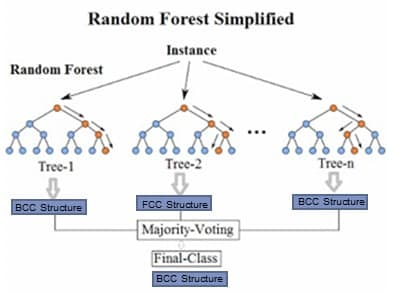

In [ ]:
# Define our model 
model = RandomForestRegressor(n_estimators=5, random_state=101)

# Lets train the model with the training dataset (X for feature and y for lables)
model.fit(X=train_features, y=train_labels)

# Used the trained model to predict on the test dataset and save it in a variable
pred = model.predict(test_features)

# Let us print the accuracy (coefficient of determiantion) of the prediction
print(f"Model Score: {model.score(test_features, test_labels)}")


# Calculate the absolute errors
errors = abs(pred - test_labels)
# Print out the mean absolute error (mae)
print(f"Mean Absolute Error: {round(np.mean(errors), 3)} Volts.")

## Hyperparameter tuning

Tuning a model is essential to avoid-overfitting and find the right parameter for training your model. Many packages can help you to tune your model including GridSearchCV, RandomSearchCV from scikit-learn, scikit-optimize, hyperopt, GpyOpt and etc. Below you can see an example of how to use one of these (i.e. BayesSearchCV).   

In [ ]:
param_grid = {'bootstrap': Categorical([True, False]),
              'max_depth': Integer(3,20),
              'min_samples_leaf': Integer(1,4),
              'n_estimators': Integer(10,60)}

@ignore_warnings(category=ConvergenceWarning) 
def model_hypertuning(model, train_feature, train_labels, test_features, param_grid, n_iteration):
  bayes_search = BayesSearchCV(estimator = model, search_spaces= param_grid, n_iter=n_iteration, random_state=1337)


  # Lets train the model with the training dataset (X for feature and y for lables)
  bayes_search.fit(X=train_features, y=train_labels)

  # Used the trained model to predict on the test dataset and save it in a variable
  pred = model.predict(test_features)

  # Let us print the accuracy (coefficient of determiantion) of the prediction
  r2_score = model.score(test_features, test_labels)
  print(f"Model Score: {r2_score}")


  # Calculate the absolute errors
  errors = abs(pred - test_labels)
  # Print out the mean absolute error (mae)
  print(f"Mean Absolute Error: {round(np.mean(errors), 3)} Volts.")
  return errors, r2_score

errors, r2_score = model_hypertuning(model, train_features, train_labels, test_features, param_grid, n_iteration=30)

### **Visualization**

For visualizing the actual values compared to our predictions, we can write a simple plotting functions that takes the actual values on the x axis and the predicted values on the y axis. We can use Matplotlib for producing a scatter plot

In [ ]:
# A fucntion for visualzing the regression
def plot_regression_results(y_true, y_pred, title):
    """Scatter plot of the predicted vs true targets."""
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],"--r", linewidth=2)
    plt.scatter(x=y_true, y=y_pred)
    plt.xlabel("Measured Values [V]")
    plt.ylabel("Predicted Values [V]")
    plt.title(title)


# Call the function with our predictions
plot_regression_results(y_true=test_labels, y_pred=pred, title="Comparision of predicted and actual values")

Let us also look at the performance of a tree with the help of the export_graphviz function of sklearn and pydot

In [ ]:
# Pull out one tree from the forest
tree = model.estimators_[4]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Display the png
Image("tree.png")

### **Exercise**

Your task is to retrain the the same dataset with a different regressor
Use the Sklear GaussianProcessRegressor and display the result similarly to what shown in the previous sections.

[Reference for Sklearn documentation of GaussianProcess](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)